# Text analysis in finance

So far we mostly discussed different methods how text can be transformed into numerical representations. Starting from frequency based bag-of-word type representations to methods including semantic meaning like Word2Vec to methods like BERT including context information. Given we generate the numerical representation of text, we may use it for different applications which are specific for the domain, i.e., for us it is the domain of financial markets. So let us take a look at common goals for financial text analysis. 

A very popular one is the detection of sentiment of financial text, e.g., are news about a company negative, neutral or negative. Furthermore, besides sentiment analysis, the disclosure of topics in financial reports can be of high interest. For instance, how does a company reports about its risk management of its exposure to risk factors as the development of the economy or its exposure to non-financial risk factors including environmental, social or governance issues of the company.

Why would anyone care about these things? With a very general point of view, financial markets are about the distribution of money where, if everything behaves as desired, money is transferred to entities which seem to be best in creating values. Again, values is a very general description for things such as the development of products and services of high quality. Usually, the ones which succeed best in generating values are the ones which make large gains and grow in value. This means investors on financial markets want to transfer their funds to the most promising entities with this respect. To achieve this goal, investors make use of all information available. Starting from quantitative facts such as numbers from, e.g., balance sheet and financial statements, to the content of financial reports, news, earning calls, etc. Whenever information is published which impacts future earnings, investor's adjust their expectation of a company's value and by this means the price they are willing to pay for an asset. 

Bringing this narrative to financial texts, investor want to be informed about aspects which may be relevant for the company's future. Given the immense amount of textual information on financial markets, they are in need of tools supporting their information gathering process. This is why text models which are able to automatically generate information on the content of financial texts are relevant and needed.

## Non-noisy vs noise tasks

If we want to evaluate the performance of a financial text model, we need labels which relate to text information, e.g., is the sentence positive, neutral or negative. One way to create these labels is by manual labeling which means that we select a number of text examples and label them ourselves. The positive aspect of manual labeling is that a genuine and direct link exists between text information and its label. On the negative side, labeling is a time-consuming process which can adversely be impacted by subjection. An alternative to manual labeling in the financial domain is to treat market reactions as the label, i.e., if the price of an asset in- or decreases after the release of textual information, the reaction of the market is treated as a label of positive (price increase) or negative (price decrease). This liberates us from manual labeling, however, comes along with some drawbacks. For instance, the text may include information which is relevant for the assets future development, but, investors do not react towards the information, given they learned about it before from other sources. Or, the information in the text is irrelevant for the assets future, however the market reacts to other developments, e.g., future adverse conditions of the economy. Bottom line, the link between text and market reactions is rather blurry and noisy.

## Quantifying stock market reactions

Nevertheless, market reactions are more often used in research due to its easier access and broader availability. So let us take a look how we exactly quantify stock market reactions. Given the price of an asset $s_t$ at time $t$, we define the discrete return of this asset as:

$$
r_t = \frac{s_{t} - s_{t-1}}{s_{t-1}} = \frac{s_{t}}{s_{t-1}} - 1
$$

Sometimes, one may use the log-return instead which is defined by:

$$
z_t = \ln \left( \frac{s_{t}}{s_{t-1}} \right) = \ln \left(1 + r_t\right)
$$

The choice between discrete or log-returns depends on the assumption of discrete vs. continuous trading of assets and a few practical considerations such as discrete returns are additive in the cross-section (at a given point in time) and log-returns are additive over time. 

Given the return of an asset at $t$ at which textual information is published, one whishes to determine if or how the information is affecting the return and by these means, the market value of an asset. To do this properly, one should filter the return for systematic developments. If you take a look in the plot below, you observe the relative stock price development for large US stocks and two major indices (Russell 3000 and S\&P 500). We can see that all assets massively loose value in March 2020. This development occurred in the beginning of the Covid crisis which had a systematic impact on all assets. Systematic market movements like these are not related to company specific information and thus, should be filtered first to isolate the relationship between company information and asset price development. Note that this holds true for all kinds of systematic developments, financial upswing as well as downturn periods. 

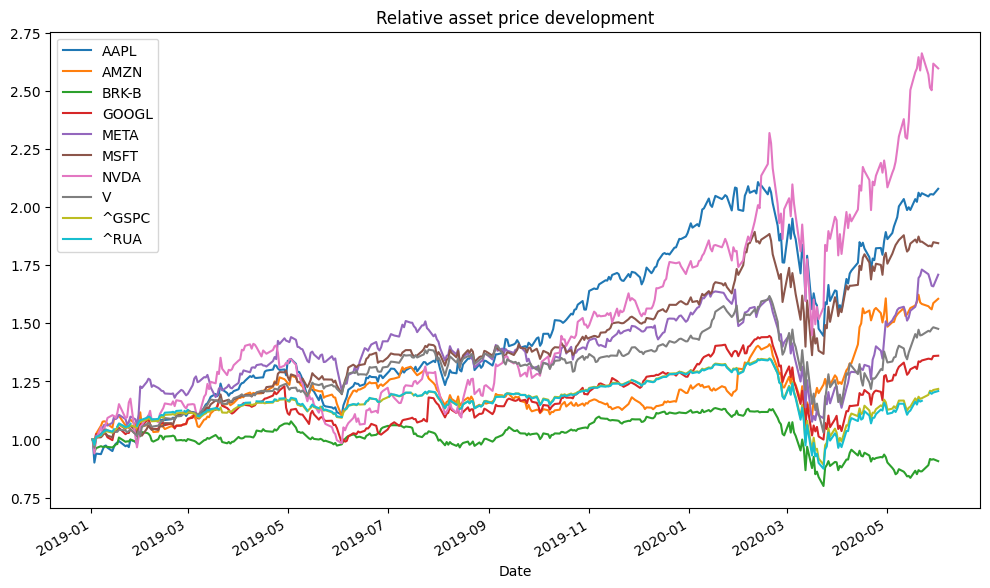

In [1]:
import pandas as pd

df_close = pd.read_csv("../data/stock_prices.csv", index_col="Date")
df_close.index = pd.to_datetime(df_close.index)

df_ttr = df_close.divide(df_close.iloc[0, :])
ttr_plot = df_ttr.loc[:pd.to_datetime("2020-06-01"), :].plot(figsize = (12, 7), title = "Relative asset price development").legend(loc = "upper left")
df_returns = df_close.divide(df_close.shift(1)).subtract(1).dropna()

A common way to filter for systematic influences is to determine the expected return for an asset conditional on systematic factors by means of regression type models like this one:

$$
r_t = \beta_0 + \boldsymbol{\beta}^T \boldsymbol{f}_t + \epsilon_t
$$

where $\boldsymbol{f}_t^T = \begin{pmatrix} f_{t, 1} & f_{t, 2} & f_{t, 3} & ...  \end{pmatrix} $ are the observations for a number of systematic factors at $t$. For instance, let us assume to use one factor only for stock market companies, we may regress each stock's return $r_{t, i}$ on a stock market portfolio return $r_{t, m}$. To keep this simple at this stage, let us use a broad market index like the Russell 3000 to approximate the market portfolio. Common approaches in the financial area to capture these systematic effects more appropriately are factor models like the capital asset pricing model, the Fama-French three factor or the Carhardt four factor model. 

The output in the cell below is based on a model which regresses the Apple return upon the return of the Russell 3000 index:

$$
r_{t, AAPL} = \beta_0 + \beta_1 r_{t, R3000} + \epsilon_t
$$

From this regression model, we know that the expected value for Apple, given the realization of the Russell 3000 return is equal to: $\mu_{t, AAPL | r_{t, R3000}} = \beta_0 + \beta_1 r_{t, R3000}$; the filtered abnormal return is given by:

$$
\epsilon_t = r_{t, AAPL} - \beta_0 - \beta_1 r_{t, R3000}
$$

The cell below illustrates Apple's filtered and unfiltered return in the first half of 2020. We observe, that especially in the financial downturn month of the Covid pandemic (March 2020), Apple's development has been not as worse as the overall market development. 

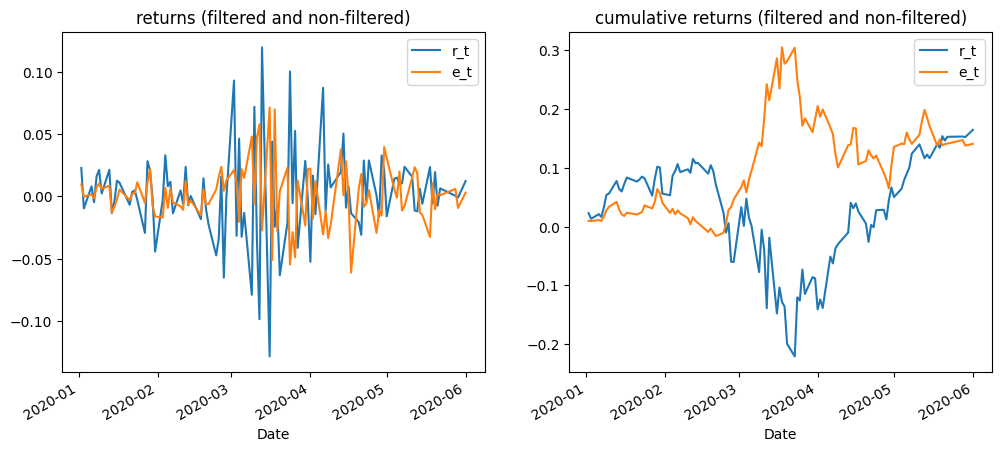

In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt

start_regression = pd.to_datetime("2019-01-01")
end_regression = pd.to_datetime("2020-01-01")
end_out_of_time = pd.to_datetime("2020-06-01")

ticker = "AAPL"
portfolio = "^RUA"
X = df_returns.loc[start_regression:end_regression, portfolio].values.reshape(-1, 1)
y = df_returns.loc[start_regression:end_regression, ticker].values

lr = LinearRegression()
lr.fit(X, y)

#b0, b1 = lr.intercept_, lr.coef_

X_oot = df_returns.loc[end_regression:end_out_of_time, portfolio].values.reshape(-1, 1)
y_oot = df_returns.loc[end_regression:end_out_of_time, ticker].values

e_oot = y_oot - lr.predict(X_oot)
results = pd.DataFrame(data = dict(r_t = y_oot, e_t = e_oot), index = df_returns.loc[end_regression:end_out_of_time].index)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
results.plot(title = "returns (filtered and non-filtered)", ax = axs[0])
results.cumsum().plot(title = "cumulative returns (filtered and non-filtered)", ax = axs[1])
plt.show()

Financial research papers often use the cumulative abnormal return over a short period around a date at which information has been published to the public. For instance, if a news article or a financial report has been published at time $t$, the reaction of the market towards this information may be captured by the abnormal market price development from $t-1$ to $t$ which is given by $\epsilon_t$ plus the abnormal market price development from $t$ to $t+1$ which is given by $\epsilon_{t+1}$. The cumulative abnormal return for window size $w$ is given by:

$$
car_{t, w} = \sum_{t=1}^{w-1} \epsilon_t
$$

Note that a model which is able to predict $car_{t, w}$ can not be utilized for a profitable investment strategy because we need to wait until $t$ at which the information is published to use the model, however, the $car_{t, w}$ is calculated assuming a long position in an asset at $t-1$. Yet, $car_{t, w}$ can be used to gain a deeper understanding how market participants process different types of information. Positive values are interpreted as positive reactions and vice versa. 

The cell below shows the filing dates of form 8-K, 10-Q and 10-K filings made by Apple in the first half of 2020. While form 10-Q and 10-K filings refer to regular quarter and annual reports, form 8-K filings are reports which must be filed when major events occur that shareholders should know about. 

In [3]:
apple_filings_all = pd.read_csv("../data/apple_filings_all.csv")
apple_filings_all.index = pd.to_datetime(apple_filings_all.filingDate)
apple_filings_all.sort_index(inplace = True)
apple_filings_all.loc[end_regression:end_out_of_time, ]

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,ticker,cik
filingDate,,,,,,,,,,,,,,,,
2020-01-28,0000320193-20-000008,2020-01-28,2020-01-28,2020-01-28T16:30:40.000Z,34.0,8-K,001-36743,20554729,"2.02,9.01",531866,1,1,a8-kq1202012282019.htm,8-K,AAPL,320193
2020-01-29,0000320193-20-000010,2020-01-29,2019-12-28,2020-01-28T18:02:44.000Z,34.0,10-Q,001-36743,20555794,NaN,9292589,1,1,a10-qq1202012282019.htm,10-Q,AAPL,320193
2020-02-18,0001193125-20-039203,2020-02-18,2020-02-17,2020-02-18T06:24:57.000Z,34.0,8-K,001-36743,20623292,"7.01,9.01",310140,1,1,d845033d8k.htm,FORM 8-K,AAPL,320193
2020-02-27,0001193125-20-050884,2020-02-27,2020-02-26,2020-02-27T06:14:21.000Z,34.0,8-K,001-36743,20658351,5.07,329670,1,1,d865740d8k.htm,8-K,AAPL,320193
2020-04-30,0000320193-20-000050,2020-04-30,2020-04-30,2020-04-30T16:30:41.000Z,34.0,8-K,001-36743,20836131,"2.02,9.01",593101,1,1,a8-kq220203282020.htm,8-K,AAPL,320193
2020-05-01,0000320193-20-000052,2020-05-01,2020-03-28,2020-04-30T18:03:10.000Z,34.0,10-Q,001-36743,20837377,NaN,10648806,1,1,a10-qq220203282020.htm,10-Q,AAPL,320193
2020-05-11,0001193125-20-139112,2020-05-11,2020-05-04,2020-05-11T16:31:15.000Z,34.0,8-K,001-36743,20865313,"8.01,9.01",771520,1,1,d926511d8k.htm,8-K,AAPL,320193


In the next cell, we take a look at the three day window cumulative abnormal returns of Apple at filing dates. We compare them with the corresponding cumulative returns of Apple and the Russell 3000. We observe mostly positive $car_{t,3}$ values at filing dates. The average value of these $car_{t, 3}$ at filing dates equals $0.0287$, while notably, the average value at days without filings is considerably lower ($0.0007$). Furthermore, it is interesting if the filing content impacts $car_{t, 3}$ values.

In [4]:
import numpy as np

russell_returns = df_returns.loc[end_regression:end_out_of_time, "^RUA"]
cumulative_values = []
for i in range(results.shape[0]-1):
    #cumulative_values.append(results.iloc[i:i+2, :].sum().values)
    cumulative_values.append(np.concatenate((results.iloc[i:i+2, :].sum().values , np.array([russell_returns.iloc[i:i+2].sum()]))))

cumulative_df = pd.DataFrame(cumulative_values, index = results.index[:-1], columns = ["cr_t", "car_t", "cr_t_russell"])
event_dates = apple_filings_all.loc[end_regression:end_out_of_time, ].index
events = cumulative_df.loc[event_dates].merge(apple_filings_all.loc[:, "form"], left_index = True, right_index = True)
urls = []
base_url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/"
for idx, row in apple_filings_all.loc[end_regression:end_out_of_time, ].iterrows():
    url = base_url + row["accessionNumber"].replace("-", "") + "/" + row["primaryDocument"]
    urls.append(url)

no_event_dates = [date for date in cumulative_df.index if not(date in event_dates)]

print(f"Average car_t values around filing days: {events.car_t.mean():.4f} \nAverage car_t values at other days: {cumulative_df.loc[no_event_dates].car_t.mean():.4f} \n{'-'*50}")
print(events)

Average car_t values around filing days: 0.0287 
Average car_t values at other days: 0.0007 
--------------------------------------------------
                cr_t     car_t  cr_t_russell  form
filingDate                                        
2020-01-28  0.049222  0.032935      0.008913   8-K
2020-01-29  0.019483  0.014677      0.001874  10-Q
2020-02-18 -0.003828 -0.009502      0.002406   8-K
2020-02-27 -0.065953  0.017331     -0.052132   8-K
2020-04-30  0.004997  0.070515     -0.041240   8-K
2020-05-01 -0.001950  0.036495     -0.024642  10-Q
2020-05-11  0.004307  0.038739     -0.022182   8-K


So, let us check this manually and read a little of the filings content which can be accessed by the links below.

| $car_{t, 3}$ | url |
|--|--|
|$0.0329$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000008/a8-kq1202012282019.htm|
|$0.0147$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000010/a10-qq1202012282019.htm|
|$-0.0095$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520039203/d845033d8k.htm|
|$0.0173$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520050884/d865740d8k.htm|
|$0.0705$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000050/a8-kq220203282020.htm|
|$0.0365$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000052/a10-qq220203282020.htm|
|$0.0387$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520139112/d926511d8k.htm|

It seems that the $car_{t, 3}$ around each filing seems to be strongly related to the content of each filing. This is exactly where text analysis enters the stage. The more accurate the text model is in predicting the $car_{t, w}$, the better it captures the reaction of market participants towards textual information. Once we estimate a model successfully which uses text as input and outputs predictions for the $car_{t, w}$ we can use the prediction as an approximation for the financial tone, i.e., if market participants identify the information to have a positive or negative impact on the future market value of an asset. Different approaches for this purpose have been analyzed in the previous literature, so let us take a look at some examples. 